#Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
import os
import random
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import auc
from sklearn.utils import shuffle

BASE_DIR = '/content/drive/Shareddrives/DeepLearningProject/Coccomini_Gholami_Zara/data/numpy data/'
MODELS_DIR = '/content/drive/Shareddrives/DeepLearningProject/Coccomini_Gholami_Zara/models/MC/'

PUBLIC_TEST_TENSOR = BASE_DIR + 'public_test_tensor.npy'
PUBLIC_TEST_LABELS = BASE_DIR + 'public_test_labels.npy'
PRIVATE_TEST_TENSOR = BASE_DIR + 'private_test_tensor.npy'

TRAIN_LABELS = BASE_DIR + 'train_labels.npy'
TRAIN_TENSOR = BASE_DIR + 'train_tensor.npy'

# training hyperparameters
RESNET_TRAIN_EPOCHS = 200
VGG16_TRAIN_EPOCHS = 50
SCRATCH_TRAIN_EPOCHS = 50
BATCH_SIZE = 16
VERBOSE = 1

RESCALE = 65535

process_manager = multiprocessing.Manager()

final_models_preds = {}
fine_tuned_models_preds = {}

In [ ]:
raw_train_data = np.load(TRAIN_TENSOR).reshape((5352, 150, 150, 1))
raw_train_labels = np.load(TRAIN_LABELS)
raw_test_data = np.load(PUBLIC_TEST_TENSOR).reshape((672, 150, 150, 1))
raw_test_labels = np.load(PUBLIC_TEST_LABELS)

# 0: baseline; 1-2: masses (b-m); 3-4: calcifications (b-m)

# Convert the dataset into a two-class one with only considering "masses" (0) and "calcifications" (1).
def collapse_labels(dataset):
  collapsed_dataset = np.where(dataset < 3, 0, 1)
  return collapsed_dataset


# Datasets without baseline (no class 0)
train_data_no_baseline =  raw_train_data[1::2]
train_labels_no_baseline =  raw_train_labels[1::2]
test_data_no_baseline =  raw_test_data[1::2]
test_labels_no_baseline =  raw_test_labels[1::2]

#copy grayscale channel to channel 2 and 3 because pretrained models work with rgb images
train_data_no_baseline_RGB = np.concatenate((train_data_no_baseline[:], train_data_no_baseline[:], train_data_no_baseline[:]), axis=3);
test_data_no_baseline_RGB = np.concatenate((test_data_no_baseline[:], test_data_no_baseline[:], test_data_no_baseline[:]), axis=3);

# Collapse labels in mass and calcification classes
collapsed_train_labels = collapse_labels(train_labels_no_baseline)
collapsed_test_labels = collapse_labels(test_labels_no_baseline)


# Datasets only baseline (only class 0)
train_data_baseline =  raw_train_data[0::2]
train_labels_baseline =  raw_train_labels[0::2]
test_data_baseline =  raw_test_data[0::2]
test_labels_baseline =  raw_test_labels[0::2]

#copy grayscale channel to channel 2 and 3 because pretrained models work with rgb images
train_data_baseline_RGB = np.concatenate((train_data_baseline[:], train_data_baseline[:], train_data_baseline[:]), axis=3);
test_data_baseline_RGB = np.concatenate((test_data_baseline[:], test_data_baseline[:], test_data_baseline[:]), axis=3);


# no baseline data RGB
train_data_nb_RGB, val_data_nb_RGB, train_labels_nb_RGB, val_labels_nb_RGB = train_test_split(
                                                                    train_data_no_baseline_RGB,
                                                                    collapsed_train_labels,
                                                                    train_size=0.8,
                                                                    random_state=42,
                                                                    shuffle=True
                                                              )

#baseline data RGB
train_data_b_RGB, val_data_b_RGB, train_labels_b_RGB, val_labels_b_RGB = train_test_split(
                                                                    train_data_baseline_RGB,
                                                                    train_labels_baseline,
                                                                    train_size=0.8,
                                                                    random_state=42,
                                                                    shuffle=True
                                                              )
# no baseline data
train_data_nb, val_data_nb, train_labels_nb, val_labels_nb = train_test_split(
                                                                    train_data_no_baseline,
                                                                    collapsed_train_labels,
                                                                    train_size=0.8,
                                                                    random_state=42,
                                                                    shuffle=True
                                                              )

#baseline data
train_data_b, val_data_b, train_labels_b, val_labels_b = train_test_split(
                                                                    train_data_baseline,
                                                                    train_labels_baseline,
                                                                    train_size=0.8,
                                                                    random_state=42,
                                                                    shuffle=True
                                                              )


###Data Visualization

In [ ]:
def show_accuracy_loss_trends(fit_results):
  acc = fit_results['accuracy']
  val_acc = fit_results['val_accuracy']
  loss = fit_results['loss']
  val_loss = fit_results['val_loss']

  epochs = range(len(acc))

  plt.figure()
  plt.ylim((0, 1))
  plt.plot(epochs, acc, 'g', label='Training acc')
  plt.plot(epochs, val_acc, 'g--', label='Validation acc')
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'r--', label='Validation loss')
  plt.legend()

  plt.show()

In [ ]:
def show_confusion_matrix(confusion_matrix):
  fig, ax = plt.subplots()
  im = ax.imshow(confusion_matrix, cmap="Blues")

  threshold = im.norm(confusion_matrix.max())/2.
  textcolors=("black", "white")

  ax.set_xticks(np.arange(2))
  ax.set_yticks(np.arange(2))
  ax.set_xticklabels(["mass", "calcification"])
  ax.set_yticklabels(["mass", "calcification"])
  
  ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

  for i in range(2):
      for j in range(2):
          text = ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", 
                         fontsize=12, color=textcolors[int(im.norm(confusion_matrix[i, j]) > threshold)])

  fig.tight_layout()
  plt.show()

In [ ]:
def show_roc_curves(models_preds):
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')

  for model, model_preds in models_preds.items():
    fpr,tpr,th = metrics.roc_curve(collapsed_test_labels,model_preds)
    model_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label= model + ' (area = {:.3f})'.format(model_auc))

  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

In [ ]:
def show_generator_images(generator):
  from tensorflow.keras.preprocessing import image

  i = 0
  var = np.asarray(next(generator))
  images = np.asarray(var[0])

  for baseline, abnormality in zip(images[0], images[1]):
      plt.figure(i)
      plt.subplot(121)
      plt.imshow(image.array_to_img(baseline), cmap="gray")
      plt.subplot(122)
      plt.imshow(image.array_to_img(abnormality), cmap="gray")
      i += 1

  plt.show()

###Data Augmentation

In [ ]:
# data augmentation hyperparameters
HORIZONTAL_FLIP = True
VERTICAL_FLIP = True
ROTATION_RANGE = 360
FILL_MODE='nearest'

def get_train_datagen(preprocess):
  from tensorflow import keras
  from keras.preprocessing.image import ImageDataGenerator
  return ImageDataGenerator(
        preprocessing_function=preprocess,
        horizontal_flip = HORIZONTAL_FLIP,
        vertical_flip = VERTICAL_FLIP, 
        rotation_range = ROTATION_RANGE,
        fill_mode=FILL_MODE
      )

def get_validation_datagen(preprocess):
  from tensorflow import keras
  from keras.preprocessing.image import ImageDataGenerator
  return ImageDataGenerator(
        preprocessing_function=preprocess
      )



def get_train_generator(baseline_data, baseline_labels, no_baseline_data, no_baseline_labels, preprocess):
  baseline_generator = get_train_datagen(preprocess).flow(baseline_data, baseline_labels, batch_size=BATCH_SIZE, shuffle=True, seed=42)
  abnormality_generator = get_train_datagen(preprocess).flow(no_baseline_data, no_baseline_labels, batch_size=BATCH_SIZE, shuffle=True, seed=42)

  while True:
          baseline = baseline_generator.next()
          abnormality = abnormality_generator.next()
          yield [baseline[0], abnormality[0]], abnormality[1]


def get_validation_generator(baseline_data, baseline_labels, no_baseline_data, no_baseline_labels, preprocess):
  baseline_generator = get_validation_datagen(preprocess).flow(baseline_data, baseline_labels, batch_size=BATCH_SIZE, shuffle=True, seed=42)
  abnormality_generator = get_validation_datagen(preprocess).flow(no_baseline_data, no_baseline_labels, batch_size=BATCH_SIZE, shuffle=True, seed=42)

  while True:
          baseline = baseline_generator.next()
          abnormality = abnormality_generator.next()
          yield [baseline[0], abnormality[0]], abnormality[1]

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


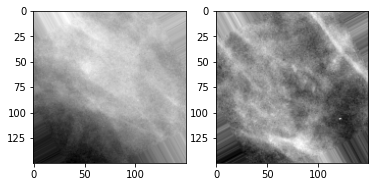

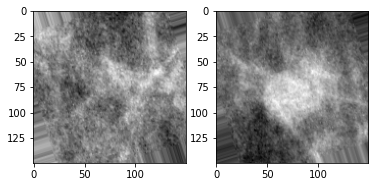

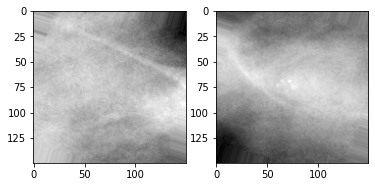

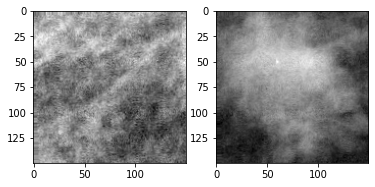

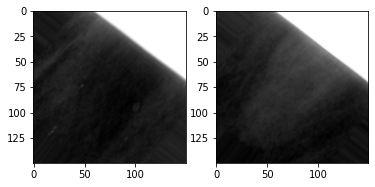

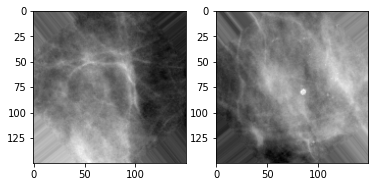

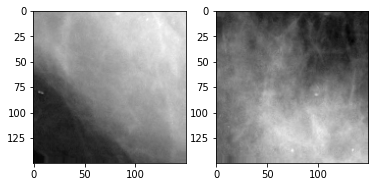

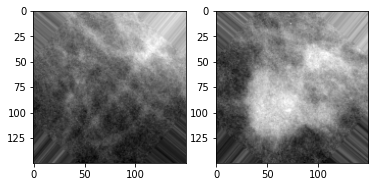

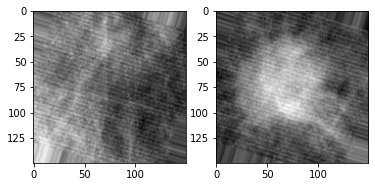

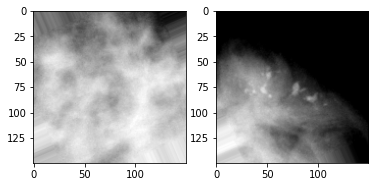

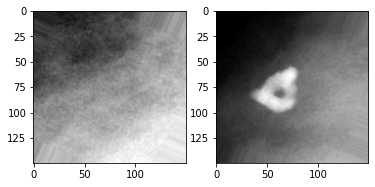

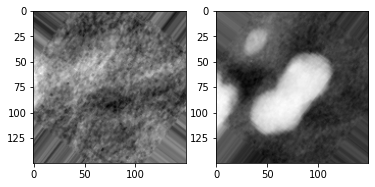

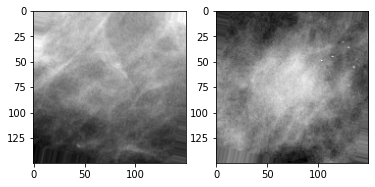

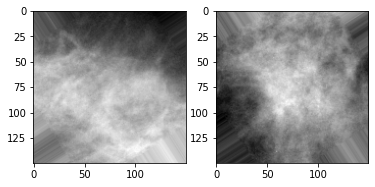

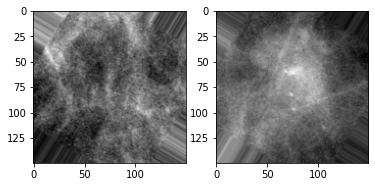

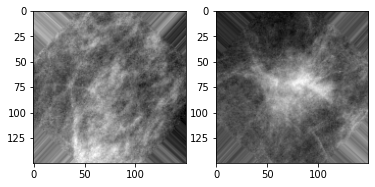

In [ ]:
def data_augmentation_example():
  train_generator = get_train_generator(train_data_b, train_labels_b, train_data_nb, train_labels_nb, None)

  show_generator_images(train_generator)


p = multiprocessing.Process(target=data_augmentation_example)
p.start()
p.join()

#Scratch

##Model architecture

In [ ]:
def get_siamese_scratch_model():
  from tensorflow import keras
  from keras import layers
  from keras import models
  from keras import regularizers
  from keras import Model

  baseline_input = keras.Input(shape=(150, 150, 1))
  abnormality_input = keras.Input(shape=(150, 150, 1))

  scratch_conv_base = keras.models.Sequential()
  kernel_size = (3,3)
  pool_size= (2,2)
  first_filters = 32
  second_filters = 64
  third_filters = 128

  dropout_conv = 0.3

  reg = regularizers.l1_l2(l1=1e-9, l2=1e-8)
  scratch_conv_base.add(layers.Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (150, 150, 1)))
  scratch_conv_base.add(layers.Conv2D(first_filters, kernel_size, activation = 'relu'))
  scratch_conv_base.add(layers.Conv2D(first_filters, kernel_size, activation = 'relu'))
  scratch_conv_base.add(layers.MaxPooling2D(pool_size = pool_size)) 

  scratch_conv_base.add(layers.Conv2D(second_filters, kernel_size, activation ='relu'))
  scratch_conv_base.add(layers.Conv2D(second_filters, kernel_size, activation ='relu'))
  scratch_conv_base.add(layers.Conv2D(second_filters, kernel_size, activation ='relu'))
  scratch_conv_base.add(layers.MaxPooling2D(pool_size = pool_size))

  scratch_conv_base.add(layers.Flatten())

  encoded_baseline = scratch_conv_base(baseline_input)
  encoded_abnormality = scratch_conv_base(abnormality_input)

  # Add a customized layer to compute the difference between the encodings
  subtract_layer = keras.layers.Subtract()([encoded_baseline/65535, encoded_abnormality/65535])

  # Add a dense layer with a sigmoid unit to generate the similarity score
  dense_1 = layers.Dense(256,activation='sigmoid')(subtract_layer)
  prediction = layers.Dense(1,activation='sigmoid')(dense_1)

  # Connect the inputs with the outputs
  siamese_model = Model(inputs=[baseline_input, abnormality_input], outputs=prediction)


  ada = keras.optimizers.Adam(learning_rate=0.001)
  # sgd = keras.optimizers.SGD(learning_rate=0.1)
  # rms = keras.optimizers.RMSprop(lr=2e-6)
  siamese_model.compile(loss="binary_crossentropy", optimizer=ada, metrics=['accuracy'])

  return siamese_model

##Training and Evaluation

In [ ]:
def scratch_test(scratch_preds):
  if VERBOSE == 1: print("Testing")
  scratch_train_generator = get_train_generator(train_data_b, train_labels_b, train_data_nb, train_labels_nb, None)
  scratch_validation_generator = get_validation_generator(val_data_b, val_labels_b, val_data_nb, val_labels_nb, None)

  final_model = get_siamese_scratch_model()
  fit_results = final_model.fit(
      scratch_train_generator,
      epochs=SCRATCH_TRAIN_EPOCHS,
      steps_per_epoch=int(np.ceil(len(train_data_b) / float(BATCH_SIZE))),
      validation_data=scratch_validation_generator,
      validation_steps=int(np.ceil(len(train_data_b) / float(BATCH_SIZE))),
      verbose=VERBOSE
  )
  
  show_accuracy_loss_trends(fit_results.history)

  preds = final_model.predict([test_data_baseline, test_data_no_baseline])

  for pred in preds:
    scratch_preds.append(pred[0])
  
  final_model.save(os.path.join(MODELS_DIR,'baseline_scratch.h5'))

Testing
Epoch 1/50
134/134 [==============================] - 16s 99ms/step - loss: 0.6843 - accuracy: 0.6018 - val_loss: 0.6616 - val_accuracy: 0.5637
Epoch 2/50
134/134 [==============================] - 12s 90ms/step - loss: 0.6301 - accuracy: 0.6608 - val_loss: 0.5622 - val_accuracy: 0.7259
Epoch 3/50
134/134 [==============================] - 12s 91ms/step - loss: 0.5950 - accuracy: 0.7103 - val_loss: 0.5388 - val_accuracy: 0.7339
Epoch 4/50
134/134 [==============================] - 12s 92ms/step - loss: 0.5518 - accuracy: 0.7274 - val_loss: 0.5508 - val_accuracy: 0.7410
Epoch 5/50
134/134 [==============================] - 12s 92ms/step - loss: 0.5607 - accuracy: 0.7399 - val_loss: 0.5368 - val_accuracy: 0.7486
Epoch 6/50
134/134 [==============================] - 12s 92ms/step - loss: 0.5487 - accuracy: 0.7377 - val_loss: 0.5514 - val_accuracy: 0.7240
Epoch 7/50
134/134 [==============================] - 12s 91ms/step - loss: 0.5353 - accuracy: 0.7412 - val_loss: 0.5365 - val_a

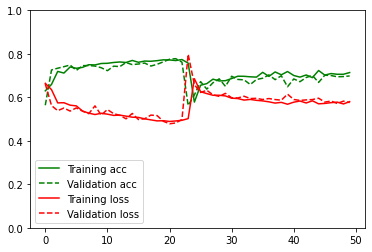

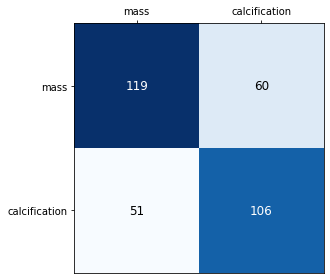


Scratch test accuracy: 0.6696428571428571


In [ ]:
preds = process_manager.list()

#execute testing in a secondary process to avoid RAM saturation
p = multiprocessing.Process(target=scratch_test, args=(preds, ))
p.start()
p.join()

preds = np.asarray(preds)

show_confusion_matrix(metrics.confusion_matrix(collapsed_test_labels, np.rint(preds)))
print("\nScratch test accuracy: " + str(metrics.accuracy_score(collapsed_test_labels, np.rint(preds))))

final_models_preds.update({"scratch": preds})

#ResNet50

##Model architecture

In [ ]:
def get_siamese_resnet_model():
  from tensorflow import keras
  from keras import layers
  from keras import models
  from keras.applications import ResNet50

  baseline_input = keras.Input(shape=(150, 150, 3))
  abnormality_input = keras.Input(shape=(150, 150, 3))

  ResNet50_conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
  ResNet50_conv_base.trainable = False

  flatten_layer = layers.Flatten()

  encoded_baseline = flatten_layer(ResNet50_conv_base(baseline_input))
  encoded_abnormality = flatten_layer(ResNet50_conv_base(abnormality_input))

  # Add a customized layer to compute the difference between the encodings
  subtract_layer = keras.layers.Subtract()([encoded_baseline/65535, encoded_abnormality/65535])

  # Add a dense layer with a sigmoid unit to generate the similarity score
  dense_1 = layers.Dense(256,activation='sigmoid')(subtract_layer)
  prediction = layers.Dense(1,activation='sigmoid')(dense_1)

  # Connect the inputs with the outputs
  siamese_model = Model(inputs=[baseline_input, abnormality_input], outputs=prediction)


  ada = keras.optimizers.Adam(learning_rate=0.001)
  # sgd = keras.optimizers.SGD(learning_rate=0.1)
  # rms = keras.optimizers.RMSprop(lr=2e-6)
  siamese_model.compile(loss="binary_crossentropy", optimizer=ada, metrics=['accuracy'])

  return siamese_model

##Training and Evaluation

In [ ]:
def resnet_test(resnet_preds):
  if VERBOSE == 1: print("Testing")
  from keras.applications.resnet import preprocess_input as resnet_preprocess

  resnet_train_generator = get_train_generator(train_data_b_RGB, train_labels_b_RGB, train_data_nb_RGB, train_labels_nb_RGB, resnet_preprocess)
  resnet_validation_generator = get_validation_generator(val_data_b_RGB, val_labels_b_RGB, val_data_nb_RGB, val_labels_nb_RGB, resnet_preprocess)

  final_model = get_siamese_resnet_model()
  fit_results = final_model.fit(
      resnet_train_generator,
      epochs=RESNET_TRAIN_EPOCHS,
      steps_per_epoch=int(np.ceil(len(train_data_b_RGB) / float(BATCH_SIZE))),
      validation_data=resnet_validation_generator,
      validation_steps=int(np.ceil(len(train_data_b_RGB) / float(BATCH_SIZE))),
      verbose=VERBOSE
  )
  
  show_accuracy_loss_trends(fit_results.history)

  preds = final_model.predict([test_data_baseline_RGB, test_data_no_baseline_RGB])

  for pred in preds:
    resnet_preds.append(pred[0])
  
  final_model.save(os.path.join(MODELS_DIR,'baseline_resnet.h5'))

Testing
Epoch 1/200
134/134 [==============================] - 39s 239ms/step - loss: 0.6605 - accuracy: 0.6185 - val_loss: 0.6001 - val_accuracy: 0.6538
Epoch 2/200
134/134 [==============================] - 29s 221ms/step - loss: 0.5914 - accuracy: 0.6921 - val_loss: 0.5475 - val_accuracy: 0.7339
Epoch 3/200
134/134 [==============================] - 30s 221ms/step - loss: 0.5716 - accuracy: 0.7145 - val_loss: 0.5297 - val_accuracy: 0.7396
Epoch 4/200
134/134 [==============================] - 29s 221ms/step - loss: 0.5358 - accuracy: 0.7388 - val_loss: 0.5203 - val_accuracy: 0.7339
Epoch 5/200
134/134 [==============================] - 29s 221ms/step - loss: 0.5360 - accuracy: 0.7476 - val_loss: 0.5144 - val_accuracy: 0.7628
Epoch 6/200
134/134 [==============================] - 30s 222ms/step - loss: 0.5084 - accuracy: 0.7556 - val_loss: 0.5137 - val_accuracy: 0.7633
Epoch 7/200
134/134 [==============================] - 30s 221ms/step - loss: 0.5601 - accuracy: 0.7257 - val_loss: 

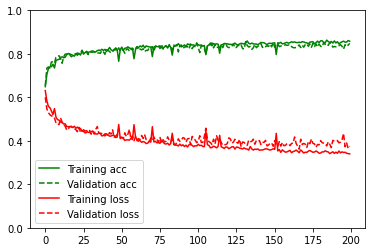

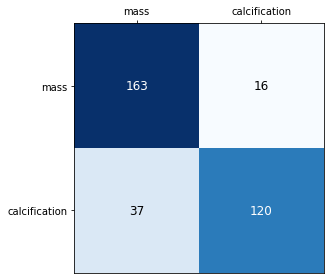


Resnet test accuracy: 0.8422619047619048


In [ ]:
preds = process_manager.list()

#execute testing in a secondary process to avoid RAM saturation
p = multiprocessing.Process(target=resnet_test, args=(preds, ))
p.start()
p.join()

preds = np.asarray(preds)

show_confusion_matrix(metrics.confusion_matrix(collapsed_test_labels, np.rint(preds)))
print("\nResnet test accuracy: " + str(metrics.accuracy_score(collapsed_test_labels, np.rint(preds))))

final_models_preds.update({"resnet": preds})

#VGG16

##Model architecture

In [ ]:
def get_siamese_vgg16_model():
  from tensorflow import keras
  from keras import layers
  from keras import models
  from keras.applications import VGG16
  from keras import Model

  baseline_input = keras.Input(shape=(150, 150, 3))
  abnormality_input = keras.Input(shape=(150, 150, 3))

  VGG16_conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
  VGG16_conv_base.trainable = False

  flatten_layer = layers.Flatten()

  encoded_baseline = flatten_layer(VGG16_conv_base(baseline_input))
  encoded_abnormality = flatten_layer(VGG16_conv_base(abnormality_input))

  # Add a customized layer to compute the difference between the encodings
  subtract_layer = keras.layers.Subtract()([encoded_baseline/65535, encoded_abnormality/65535])

  # Add a dense layer with a sigmoid unit to generate the similarity score
  dense_1 = layers.Dense(256,activation='sigmoid')(subtract_layer)
  prediction = layers.Dense(1,activation='sigmoid')(dense_1)

  # Connect the inputs with the outputs
  siamese_model = Model(inputs=[baseline_input, abnormality_input], outputs=prediction)


  ada = keras.optimizers.Adam(learning_rate=0.001)
  # sgd = keras.optimizers.SGD(learning_rate=0.1)
  # rms = keras.optimizers.RMSprop(lr=2e-6)
  siamese_model.compile(loss="binary_crossentropy", optimizer=ada, metrics=['accuracy'])

  return siamese_model

##Training and Evaluation

In [ ]:
def vgg16_test(vgg16_preds):
  if VERBOSE == 1: print("Testing")
  from keras.applications.vgg16 import preprocess_input as vgg16_preprocess

  vgg16_train_generator = get_train_generator(train_data_b_RGB, train_labels_b_RGB, train_data_nb_RGB, train_labels_nb_RGB, vgg16_preprocess)
  vgg16_validation_generator = get_validation_generator(val_data_b_RGB, val_labels_b_RGB, val_data_nb_RGB, val_labels_nb_RGB, vgg16_preprocess)

  final_model = get_siamese_vgg16_model()
  fit_results = final_model.fit(
      vgg16_train_generator,
      epochs=VGG16_TRAIN_EPOCHS,
      steps_per_epoch=int(np.ceil(len(train_data_b_RGB) / float(BATCH_SIZE))),
      validation_data=vgg16_validation_generator,
      validation_steps=int(np.ceil(len(train_data_b_RGB) / float(BATCH_SIZE))),
      verbose=VERBOSE
  )
  
  show_accuracy_loss_trends(fit_results.history)

  preds = final_model.predict([test_data_baseline_RGB, test_data_no_baseline_RGB])

  for pred in preds:
    vgg16_preds.append(pred[0])
  
  final_model.save(os.path.join(MODELS_DIR,'baseline_vgg16.h5'))

Testing
Epoch 1/50
134/134 [==============================] - 36s 242ms/step - loss: 0.6317 - accuracy: 0.6288 - val_loss: 0.5591 - val_accuracy: 0.6472
Epoch 2/50
134/134 [==============================] - 31s 231ms/step - loss: 0.5173 - accuracy: 0.7627 - val_loss: 0.5108 - val_accuracy: 0.7779
Epoch 3/50
134/134 [==============================] - 32s 239ms/step - loss: 0.4685 - accuracy: 0.7941 - val_loss: 0.4876 - val_accuracy: 0.8063
Epoch 4/50
134/134 [==============================] - 31s 236ms/step - loss: 0.4327 - accuracy: 0.8126 - val_loss: 0.4876 - val_accuracy: 0.7708
Epoch 5/50
134/134 [==============================] - 32s 236ms/step - loss: 0.4212 - accuracy: 0.8102 - val_loss: 0.4708 - val_accuracy: 0.8068
Epoch 6/50
134/134 [==============================] - 32s 237ms/step - loss: 0.3889 - accuracy: 0.8218 - val_loss: 0.4632 - val_accuracy: 0.7931
Epoch 7/50
134/134 [==============================] - 31s 236ms/step - loss: 0.4185 - accuracy: 0.8254 - val_loss: 0.4643 

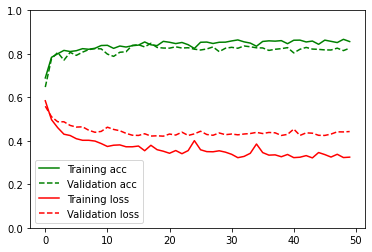

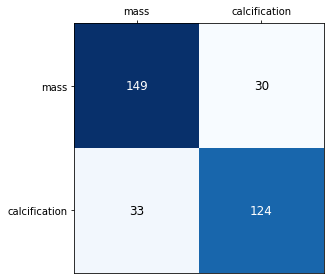


Vgg16 test accuracy: 0.8125


In [ ]:
preds = process_manager.list()

#execute testing in a secondary process to avoid RAM saturation
p = multiprocessing.Process(target=vgg16_test, args=(preds, ))
p.start()
p.join()

preds = np.asarray(preds)

show_confusion_matrix(metrics.confusion_matrix(collapsed_test_labels, np.rint(preds)))
print("\nVgg16 test accuracy: " + str(metrics.accuracy_score(collapsed_test_labels, np.rint(preds))))

final_models_preds.update({"vgg16": preds})

#Comparisons

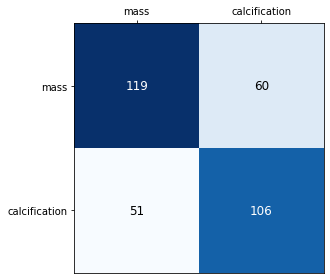


scratch test accuracy: 0.6696428571428571


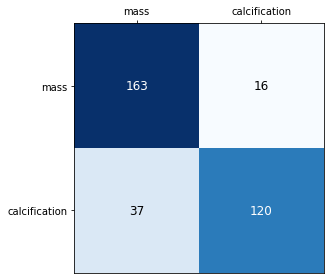


resnet test accuracy: 0.8422619047619048


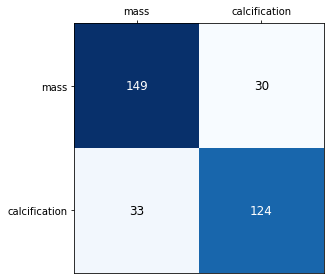


vgg16 test accuracy: 0.8125


In [ ]:
def load_models(preds, model_name):
  from keras.models import load_model

  current_model = load_model(os.path.join(MODELS_DIR,'baseline_'+model_name+'.h5'))
  if model_name == "scratch":
    model_preds = current_model.predict([test_data_baseline, test_data_no_baseline])
  else:
    model_preds = current_model.predict([test_data_baseline_RGB, test_data_no_baseline_RGB])

  for pred in model_preds:
    preds.append(pred[0])


#execute fine tuning in a secondary process to avoid RAM saturation
models = ["scratch", "resnet", "vgg16"]
for model in models:
  preds = process_manager.list()
  p = multiprocessing.Process(target=load_models, args=(preds, model))
  p.start()
  p.join()

  preds = np.asarray(preds)

  show_confusion_matrix(metrics.confusion_matrix(collapsed_test_labels, np.rint(preds)))
  print("\n" + model + " test accuracy: " + str(metrics.accuracy_score(collapsed_test_labels, np.rint(preds))))

  final_models_preds.update({model: preds})

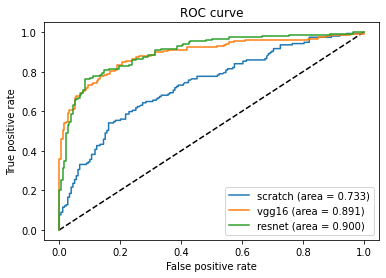

In [ ]:
show_roc_curves(final_models_preds)

# Fine Tuning

##Resnet

In [ ]:
def resnet_fine_tuning(resnet_preds):
  if VERBOSE == 1: print("Testing")
  import keras
  from keras.models import load_model
  from keras.applications.resnet import preprocess_input as resnet_preprocess
  
  resnet_train_generator = get_train_generator(train_data_b_RGB, train_labels_b_RGB, train_data_nb_RGB, train_labels_nb_RGB, resnet_preprocess)
  resnet_validation_generator = get_validation_generator(val_data_b_RGB, val_labels_b_RGB, val_data_nb_RGB, val_labels_nb_RGB, resnet_preprocess)

  final_model = load_model(os.path.join(MODELS_DIR,'baseline_resnet.h5'))

  convolutional_layer = final_model.get_layer("resnet50") 
  
  for layer in convolutional_layer.layers:
    layer.trainable = False

  for layer in convolutional_layer.layers:
      if layer.name == "conv5_block3_3_conv":
        layer.trainable = True
  
  ada = keras.optimizers.Adam(learning_rate=0.0001)
  final_model.compile(loss="binary_crossentropy", optimizer=ada, metrics=['accuracy'])

  fit_results = final_model.fit(
      resnet_train_generator,
      epochs=RESNET_TRAIN_EPOCHS,
      steps_per_epoch=int(np.ceil(len(train_data_b_RGB) / float(BATCH_SIZE))),
      validation_data=resnet_validation_generator,
      validation_steps=int(np.ceil(len(train_data_b_RGB) / float(BATCH_SIZE))),
      verbose=VERBOSE
  )

  show_accuracy_loss_trends(fit_results.history)

  preds = final_model.predict([test_data_baseline_RGB, test_data_no_baseline_RGB])
  for pred in preds:
    resnet_preds.append(pred[0])
  
  final_model.save(os.path.join(MODELS_DIR,'baseline_resnet_tuned.h5'))


Testing
Epoch 1/200
134/134 [==============================] - 43s 235ms/step - loss: 0.3411 - accuracy: 0.8564 - val_loss: 0.3810 - val_accuracy: 0.8396
Epoch 2/200
134/134 [==============================] - 29s 221ms/step - loss: 0.3612 - accuracy: 0.8413 - val_loss: 0.3825 - val_accuracy: 0.8400
Epoch 3/200
134/134 [==============================] - 30s 222ms/step - loss: 0.3689 - accuracy: 0.8474 - val_loss: 0.3847 - val_accuracy: 0.8343
Epoch 4/200
134/134 [==============================] - 30s 222ms/step - loss: 0.3546 - accuracy: 0.8574 - val_loss: 0.3893 - val_accuracy: 0.8371
Epoch 5/200
134/134 [==============================] - 30s 221ms/step - loss: 0.3475 - accuracy: 0.8520 - val_loss: 0.4054 - val_accuracy: 0.8362
Epoch 6/200
134/134 [==============================] - 30s 222ms/step - loss: 0.3468 - accuracy: 0.8515 - val_loss: 0.4166 - val_accuracy: 0.8376
Epoch 7/200
134/134 [==============================] - 30s 221ms/step - loss: 0.3676 - accuracy: 0.8326 - val_loss: 

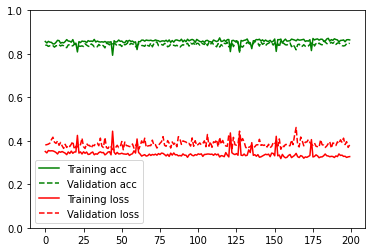

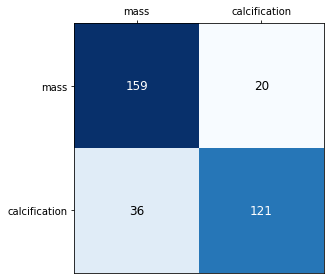


Tuned resnet test accuracy: 0.8333333333333334


In [ ]:
preds = process_manager.list()

#execute fine tuning in a secondary process to avoid RAM saturation
p = multiprocessing.Process(target=resnet_fine_tuning, args=(preds, ))
p.start()
p.join()

preds = np.asarray(preds)

show_confusion_matrix(metrics.confusion_matrix(collapsed_test_labels, np.rint(preds)))
print("\nTuned resnet test accuracy: " + str(metrics.accuracy_score(collapsed_test_labels, np.rint(preds))))

fine_tuned_models_preds.update({"resnet_tuned": preds})

##VGG16

In [ ]:
def vgg16_fine_tuning(vgg16_preds):
  if VERBOSE == 1: print("Testing")
  import keras
  from keras.models import load_model
  from keras.applications.vgg16 import preprocess_input as vgg16_preprocess

  vgg16_train_generator = get_train_generator(train_data_b_RGB, train_labels_b_RGB, train_data_nb_RGB, train_labels_nb_RGB, vgg16_preprocess)
  vgg16_validation_generator = get_validation_generator(val_data_b_RGB, val_labels_b_RGB, val_data_nb_RGB, val_labels_nb_RGB, vgg16_preprocess)

  final_model = load_model(os.path.join(MODELS_DIR,'baseline_vgg16.h5'))

  convolutional_layer = final_model.get_layer("vgg16") 

  for layer in convolutional_layer.layers:
    layer.trainable = False

  for layer in convolutional_layer.layers[-4:]:
    layer.trainable = True
 
  rms = keras.optimizers.RMSprop(lr=2e-6)
  final_model.compile(loss="binary_crossentropy", optimizer=rms, metrics=['accuracy'])

  fit_results = final_model.fit(
      vgg16_train_generator,
      epochs=VGG16_TRAIN_EPOCHS,
      steps_per_epoch=int(np.ceil(len(train_data_b_RGB) / float(BATCH_SIZE))),
      validation_data=vgg16_validation_generator,
      validation_steps=int(np.ceil(len(train_data_b_RGB) / float(BATCH_SIZE))),
      verbose=VERBOSE
  )


  show_accuracy_loss_trends(fit_results.history)

  preds = final_model.predict([test_data_baseline_RGB, test_data_no_baseline_RGB])
  for pred in preds:
    vgg16_preds.append(pred[0])
  
  final_model.save(os.path.join(MODELS_DIR,'baseline_vgg16_tuned.h5'))

Testing
Epoch 1/50
134/134 [==============================] - 43s 251ms/step - loss: 0.2949 - accuracy: 0.8746 - val_loss: 0.4420 - val_accuracy: 0.8236
Epoch 2/50
134/134 [==============================] - 32s 240ms/step - loss: 0.3205 - accuracy: 0.8622 - val_loss: 0.4322 - val_accuracy: 0.8291
Epoch 3/50
134/134 [==============================] - 33s 245ms/step - loss: 0.2962 - accuracy: 0.8703 - val_loss: 0.4281 - val_accuracy: 0.8390
Epoch 4/50
134/134 [==============================] - 33s 248ms/step - loss: 0.2832 - accuracy: 0.8952 - val_loss: 0.4286 - val_accuracy: 0.8366
Epoch 5/50
134/134 [==============================] - 33s 248ms/step - loss: 0.2785 - accuracy: 0.8862 - val_loss: 0.4253 - val_accuracy: 0.8433
Epoch 6/50
134/134 [==============================] - 33s 247ms/step - loss: 0.2587 - accuracy: 0.8936 - val_loss: 0.4117 - val_accuracy: 0.8428
Epoch 7/50
134/134 [==============================] - 33s 248ms/step - loss: 0.2951 - accuracy: 0.8656 - val_loss: 0.4204 

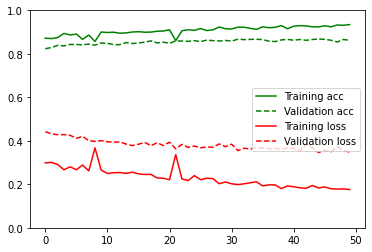

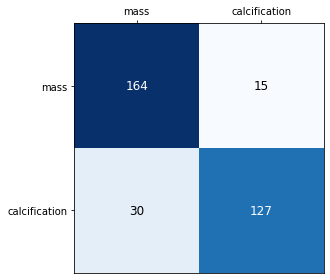


Tuned VGG16 test accuracy: 0.8660714285714286


In [ ]:
preds = process_manager.list()

#execute fine tuning in a secondary process to avoid RAM saturation
p = multiprocessing.Process(target=vgg16_fine_tuning, args=(preds, ))
p.start()
p.join()

preds = np.asarray(preds)

show_confusion_matrix(metrics.confusion_matrix(collapsed_test_labels, np.rint(preds)))
print("\nTuned VGG16 test accuracy: " + str(metrics.accuracy_score(collapsed_test_labels, np.rint(preds))))

fine_tuned_models_preds.update({"vgg16_tuned": preds})

##Comparisons

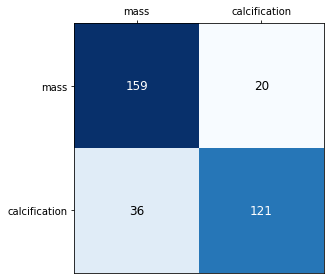


Tuned resnet_tuned test accuracy: 0.8333333333333334


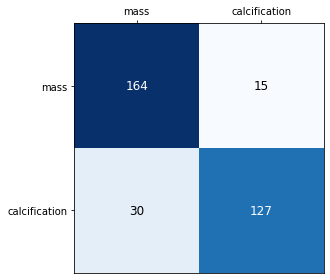


Tuned vgg16_tuned test accuracy: 0.8660714285714286


In [ ]:
def load_tuned_models(preds, model_name):
  from keras.models import load_model

  current_model = load_model(os.path.join(MODELS_DIR,'baseline_'+model_name+'.h5'))
  
  model_preds = current_model.predict([test_data_baseline_RGB, test_data_no_baseline_RGB])

  for pred in model_preds:
    preds.append(pred[0])


#execute fine tuning in a secondary process to avoid RAM saturation
models = ["resnet_tuned", "vgg16_tuned"]
for model in models:
  preds = process_manager.list()
  p = multiprocessing.Process(target=load_tuned_models, args=(preds, model))
  p.start()
  p.join()

  preds = np.asarray(preds)

  show_confusion_matrix(metrics.confusion_matrix(collapsed_test_labels, np.rint(preds)))
  print("\nTuned " + model + " test accuracy: " + str(metrics.accuracy_score(collapsed_test_labels, np.rint(preds))))

  fine_tuned_models_preds.update({model: preds})

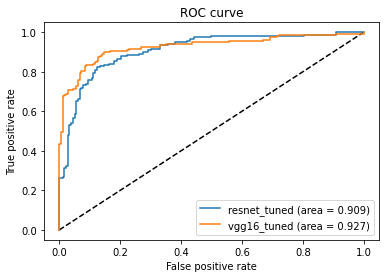

In [ ]:
show_roc_curves(fine_tuned_models_preds)